# Installing Packages

In [28]:
!pip install pydotplus
!pip install shap
!pip install dataframe-image
!pip install pandas==1.5.3

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/criminal-psychological-data/Criminal Psychological Dataset CSV.csv


# Importing Libraries

In [30]:
import shap

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from matplotlib import interactive
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

# For plotting the classification results
from mlxtend.plotting import plot_decision_regions
import xgboost as xgb
from IPython.display import Image  
import pydotplus
from six import StringIO

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import dataframe_image as dfi

import seaborn as sns
%matplotlib inline

# Output Easy Controls

Below boolean values are used to execute or skip SMOTE, NearMiss data balancing techniques or data scaling. Initially we utilized SMOTE techniques but are no longer using for final results in case of ensemble models. 

In [31]:
#Change to True if you want to use SMOTE for balancing training datasets
balanceDataset = False
#change to True if you want to scale and fill missing values
doFillScale = False
#Change to True if you want to use NearMiss for undersampling balancing
#NearMiss is undersampling - DO NOT use with SMOTE together
NearMissUnderSample = False

# Dataset Processing

In [32]:
#reading and preparing datasets
org_ds = pd.read_csv('/kaggle/input/criminal-psychological-data/Criminal Psychological Dataset CSV.csv')

#converting all columns to lowercase to standardize usage
org_ds.columns = org_ds.columns.str.lower()

#updating dataset without non-numeric unwanted fields like date, time, patient number, zero change values
numeric_ds = org_ds.drop(['cid','cjdid','staffid','idate','intstrt','instrta','suindt','stjail','pre30jl','pre180jl','cdob',
                          'chethn1','crace1','c23cmin','c23cmdt','ag1sdin','sdinj30','intend','intenda','editdate','d2bi2pma',
                          'd2bi2pmb','d2bi2pmc','c18pdmcl','c18pdmcp','c18pdmca','c18spgmc','anytxpm','datadmit','entpro',
                          'compl','onset1','neworrec','environ','course','worst','worst2','txhispsy','txdralc','hospspec',
                          'hospmed','othprob3','whowith','currdx','lifedes1','lifedes2','lifedes3','lifetx3','lifedes4',
                          'lifetx4','lifedes5','lifetx8','screen6a','s61b','s61bs','c17cmdt'] , axis = 1)



#converting categorical values to integer by One Hot Encoding
numeric_ds = pd.get_dummies(numeric_ds, columns = ['clive1','job1','majsup1','othoff','othdrug','qtother1',
                                                             'othtx1','resptx1','a38spgmc','a40spsu','c20spsu','f29spsu',
                                                             'diff1','diff2','diff3','onset2','new2','othprob1','othprob2',
                                                             'medvit','alcdrug','freetime','ruleout','lifetx1','lifeage2',
                                                             'lifetx2','lifetx5','lifedes6','lifetx6','lifedes7','lifetx7','lifedes8'])


# replace field that's entirely space (or empty) with NaN
numeric_ds = numeric_ds.replace(r'^\s*$', np.nan, regex=True)
    
for (columnName, columnData) in numeric_ds.iteritems():
    numeric_ds[columnName] = pd.to_numeric(numeric_ds[columnName])
    numeric_ds[columnName].fillna(numeric_ds[columnName].mean())
    numeric_ds[columnName] = numeric_ds[columnName].replace(np.nan, numeric_ds[columnName].mean())
    numeric_ds[columnName].astype(str).astype(float)
    
#removing special characters from feature names added by One Hot Encoding
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name. We were using LightGBM initially instead of CatBoost)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in numeric_ds.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
numeric_ds = numeric_ds.rename(columns=new_names)

#ds_woSuicide is processed dataset without features of suicide ideation
ds_woSuicide = numeric_ds.drop(['othoff_SUICIDEATTEMPTS','sidelf','mini4','mini4a','mhsf28a','mhsf29a','gain43',
                                'gain43a','gain44','gain44a','cursuic1','cursuic2','cursuic3','cursuic4','passuic1',
                                'passuic2','passuic3','passuic4','currsuic','pastsuic','sciddia1','sciddi1a','scidsev2'], axis = 1)

#ds_wSuicide is dataset with features of suicide ideation
ds_wSuicide = numeric_ds

#rds_woSuicide is reduced dataset having SHAP top features (without features of suicide ideation)
#this dataset was appended afterwards by analysis of SHAP from above processed datasets
rds_woSuicide = ds_woSuicide[['phosplf','scrns3b3','pdborder','mhsftot','scrn3md','suprob2','s65cs','alctype','age1coc',
                              'age1alc','new2_','age1tob','drgprb3','mhsf35a','hosptime','anxlf','mhsf28','s65a','d6mddlta',
                              'majsup','arstdrg','depend','drgprb2','scrns3b2','age','tcuds','c1cm30','sattlf']]

#rds_wSuicide is reduced dataset having SHAP top features (with features of suicide ideation)
#this dataset was appended afterwards by analysis of SHAP from above processed datasets
rds_wSuicide = ds_wSuicide[['mhsf28a','sidelf','gain44','phosplf','age1jl','job','age1coc','drvlic','gain44a','coc6m','aspdtot',
                            'alctype','age1tob','c7cm6m','mshf10cs','clive','gain53a','suprob2','pdborder','age1mj','drgprb6',
                            'scrns3c3','arstdrg','allmon','hosptime','gs5a','depend','sattlf']]


print("Columns in original dataset without suicide ideation" , len(ds_woSuicide.columns))
print("Columns in original dataset with suicide ideation" , len(ds_wSuicide.columns))
print("Columns in reduced dataset without suicide ideation" , len(rds_woSuicide.columns))
print("Columns in reduced dataset with suicide ideation" , len(rds_wSuicide.columns))

iteritems is deprecated and will be removed in a future version. Use .items instead.


Columns in original dataset without suicide ideation 2314
Columns in original dataset with suicide ideation 2337
Columns in reduced dataset without suicide ideation 28
Columns in reduced dataset with suicide ideation 28


In [33]:
#PROCESSED DATASET WITHOUT SUICIDE IDEATION
X = ds_woSuicide.drop(['sattlf'], axis=1) #X training features
y = ds_woSuicide.sattlf #y output features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test


#PROCESSED DATASET WITH SUICIDE IDEATION
X_s = ds_wSuicide.drop(['sattlf'], axis=1) #X training features
y_s = ds_wSuicide.sattlf #y output features
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=1) # 80% training and 20% test


#SHAP REDUCED DATASET WITHOUT SUICIDE IDEATION
X_r = rds_woSuicide.drop(['sattlf'], axis=1) #X training features
y_r = rds_woSuicide.sattlf #y output features
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=1) # 80% training and 20% test

#SHAP REDUCED DATASET WITH SUICIDE IDEATION
X_rs = rds_wSuicide.drop(['sattlf'], axis=1) #X training features
y_rs = rds_wSuicide.sattlf #y output features
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, test_size=0.2, random_state=1) # 80% training and 20% test

In [34]:
#fills missing values and scales numerics
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def FillScaleData(xTrain, xTest):
    #Impute missing values
    #create KNN imputer object
    knn_imp = KNNImputer(n_neighbors=5)
    train_imputed = knn_imp.fit_transform(xTrain)
    test_imputed = knn_imp.fit_transform(xTest)

    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    xsTrain = sc.fit_transform(train_imputed)
    xsTest = sc.fit_transform(test_imputed)
    
    return xsTrain, xsTest
    
if (doFillScale == True):
    X_train, X_test = FillScaleData(X_train, X_test)
    X_train_s, X_test_s = FillScaleData(X_train_s, X_test_s)
    X_train_r, X_test_r = FillScaleData(X_train_r, X_test_r)
    X_train_rs, X_test_rs = FillScaleData(X_train_rs, X_test_rs)

In [35]:
#balance classes using various types of SMOTE
smoteType = 1
def balanceData(xTrain, yTrain, nameText):
    if (smoteType == 0): #random smote
            #---SMOTE for class balancing
        sm = SMOTE(random_state=8)
            #---Displays perccent of each class
        print("Initial Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
            #---create new training set with SMOTE object
            
        xBal, yBal = sm.fit_resample(xTrain, yTrain)
        print("Balanced Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
        
        return xBal, yBal

    if (smoteType == 1): #borderline smote
        #Borderline SMOTE for class balancing
        #By default, the BorderlineSMOTE would use the Borderline-SMOTE1
        from imblearn.over_sampling import BorderlineSMOTE
        bsmote = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')
        print("Initial Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
            #---create new training set with SMOTE object
            
        xBal, yBal = bsmote.fit_resample(xTrain, yTrain)
        print("Balanced Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
        
        return xBal, yBal
    
    if (smoteType == 2): #borderline smote svm
        from imblearn.over_sampling import SVMSMOTE
        svmsmote = SVMSMOTE(random_state = 101)
        print("Initial Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
            #---create new training set with SMOTE object
            
        xBal, yBal = svmsmote.fit_resample(xTrain, yTrain)
        print("Balanced Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
        
        return xBal, yBal
    
    if (smoteType == 3): #Adaptive Synthetic Sampling (ADASYN) smote
        from imblearn.over_sampling import ADASYN
        adasyn = ADASYN(random_state = 101)
        print("Initial Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
            #---create new training set with SMOTE object
            
        xBal, yBal = adasyn.fit_resample(xTrain, yTrain)
        print("Balanced Dataset")
        print("Percent - " + nameText + ":" , yTrain.sum()/len(yTrain))
        
        return xBal, yBal
    
    
if (balanceDataset == True):
    X_train, y_train = balanceData(X_train, y_train, "Suicide without Suicide Ideation")
    X_train_s, y_train_s = balanceData(X_train_s, y_train_s, "Suicide with Suicide Ideation")
    X_train_r, y_train_r = balanceData(X_train_r, y_train_r, "Suicide Reduced without Suicide Ideation")
    X_train_rs, y_train_rs = balanceData(X_train_rs, y_train_rs, "Suicide Reduced with Suicide Ideation")
    

In [36]:
#balance classes using undersampling with NearMiss
#Do not use together with SMOTE oversampling
versionCall = 3
#1 to 3, default 1
def NearMissBalance(xTrain, yTrain):
    from imblearn.under_sampling import NearMiss
    nr = NearMiss(version = versionCall)

    X_train_miss, y_train_miss = nr.fit_resample(xTrain, yTrain)
    
    return X_train_miss, y_train_miss

if (NearMissUnderSample == True):
    X_train, y_train = NearMissBalance(X_train, y_train)
    X_train_s, y_train_s = NearMissBalance(X_train_s, y_train_s)
    X_train_r, y_train_r = NearMissBalance(X_train_r, y_train_r)
    X_train_rs, y_train_rs = NearMissBalance(X_train_rs, y_train_rs)

# Functions & Methods

In [37]:
#Creating Dataframe table for displaying of performance metrics for models
#required for table image creation
metrics_name = ["Accuracy(%):", "F1-Score:", "Precision:", "Sensitivity:",
               "AUC:","PPV:", "Logloss:" , "True +:", "True -:",
               "False +:", "False -:"]
metrics_val = [0,1,2,3,4,5,6,7,8,9,10]

table_df = pd.DataFrame()
table_df["Metrics"] = metrics_name

def gen_performance_metrics(classifier , YT , YP):
    TN, FP, FN, TP = confusion_matrix(YT, YP).ravel()
    metrics_val[0] = round(accuracy_score(YT, YP)*100,2)
    metrics_val[1] = round(f1_score(YT, YP, average='macro'),3)
    metrics_val[2] = round(precision_score(YT, YP, average='micro'),3)
    metrics_val[3] = round(recall_score(YT, YP, average='binary'),3)
    metrics_val[4] = round(metrics.roc_auc_score(YT, YP),3)
    metrics_val[5] = round(TP/(TP+FP),3)
    metrics_val[6] = round(log_loss(YT, YP, eps=1e-5, normalize=True, sample_weight=None, labels=None),3)
    metrics_val[7] = TP
    metrics_val[8] = TN
    metrics_val[9] = FP
    metrics_val[10] = FN
    table_df[classifier] = metrics_val

def gen_performance_metrics_prob(classifier , YT , YP , y_prob): #for classifiers having probability outputs
    TN, FP, FN, TP = confusion_matrix(YT, YP).ravel()
    metrics_val[0] = round(accuracy_score(YT, YP)*100,2)
    metrics_val[1] = round(f1_score(YT, YP, average='macro'),3)
    metrics_val[2] = round(precision_score(YT, YP, average='micro'),3)
    metrics_val[3] = round(recall_score(YT, YP, average='binary'),3)
    metrics_val[4] = round(metrics.roc_auc_score(YT, y_prob, multi_class='ovr'),3)
    metrics_val[5] = round(TP/(TP+FP),3)
    metrics_val[6] = round(log_loss(YT, y_prob, eps=1e-5, normalize=True, sample_weight=None, labels=None),3)
    metrics_val[7] = TP
    metrics_val[8] = TN
    metrics_val[9] = FP
    metrics_val[10] = FN
    table_df[classifier] = metrics_val

# Models

Below are the functions for models executions.
Models are as follows; Decision Tree, XGBoost, Random Forest, Linear Regression, Logistic Regression, Neural Network, CatBoost

In [38]:
#function for executing decision tree
def DecisionTree(xTrain, yTrain, xTest, x, pngName): #x is the original features dataset, X, X_s, X_r
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion="gini", max_depth=5)
    # Train Decision Tree Classifer
    clf = clf.fit(xTrain,yTrain)
    #Predict the response for test dataset
    yPred = clf.predict(xTest)
    
    #visualizing Decision Tree
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = x.columns)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(pngName + "_decision_tree.jpg")
    Image(graph.create_png())
    
    plt.figure(1)
    figure(figsize=(14, 12), dpi=80)
    img = mpimg.imread("/kaggle/working/" + pngName + "_decision_tree.jpg")
    plt.imshow(img)
    interactive(True)
    plt.show()

    return yPred.copy()

In [39]:
#function for executing XGBoost
def XGBoost(xTrain, yTrain, xTest, x, pngName): #x is the original features dataset, X, X_s, X_r
    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.3, 
                               booster='gbtree', max_depth=5, n_estimators=100)
    # Fit
    xgb_cl.fit(xTrain, yTrain)
    # Predict
    yPred = xgb_cl.predict(xTest)

    #visualizing shap plot for XGBoost
    X_frame = pd.DataFrame(data=x, columns=x.columns)
    explainer = shap.Explainer(xgb_cl)
    shap_values = explainer(X_frame)
    shap.plots.bar(shap_values, max_display=30,show=False)
    #plt.figure(2)
    #figure(figsize=(8, 10), dpi=80)
    plt.savefig(pngName + "_shap.jpg")
    #interactive(True)
    #plt.show()

    df_shap_values = pd.DataFrame(data=shap_values.values,columns=x.columns)
    df_feature_importance = pd.DataFrame(columns=['feature','importance'])
    for col in df_shap_values.columns:
        importance = df_shap_values[col].abs().mean()
        df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
    df_feature_importance = df_feature_importance.sort_values('importance',ascending=False)
    print(df_feature_importance.head(27))

    return yPred.copy()

In [40]:
#function for executing Random Forest
def RandomForest(xTrain, yTrain, xTest, pngName):
    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=500)
    #Train the model using the training sets
    clf.fit(xTrain,yTrain)
    yPred = clf.predict(xTest)

    return yPred.copy()

In [41]:
#function for executing linear regression
def LinearReg(xTrain, yTrain, xTest):
    model = LinearRegression().fit(xTrain, yTrain)
    yProb = model.predict(xTest)
    
    return yProb.copy()

In [42]:
#function for executing logistic regression
def LogReg(xTrain, yTrain, xTest, pngName):
    model = LogisticRegression(solver='liblinear', random_state=0).fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    
    return yPred.copy()

In [43]:
#function for executing neural network
def NN(xTrain, yTrain, xTest, yTest, x, nameText): #x is the original features dataset, X, X_s, X_r
    model = Sequential()
    model.add(Dense(12, input_shape=(len(x.columns),), activation='sigmoid'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(xTrain, yTrain, epochs=150, batch_size=10)
    accuracy = model.evaluate(xTest, yTest)
    print("Neural Network Model Accuracy " + nameText + " is : {:.2f}%".format(accuracy[1]*100,2))

    yProb = model.predict(xTest)
    
    return yProb.copy()

In [44]:
#function for executing catboost
def catBoost(xTrain, yTrain, xTest, label):
    print("CatBoost " + label)
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=0.1,
                               depth=5)
    # Fit model
    model.fit(xTrain, yTrain)
    # Get predicted classes
    yPred = model.predict(xTest)
    
    return yPred.copy()

# Model Execution on Original Dataset

Below are the models being executed on complete processed datasets while generating SHAP outputs.

[14:26:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


       feature  importance
153    phosplf    1.356258
553   pdborder    0.554332
769    scrn3md    0.547756
780   scrns3b3    0.400334
765      s65cs    0.347985
194    age1coc    0.340938
562    mhsftot    0.318437
284    suprob2    0.302014
378     mhsf28    0.295644
263    alctype    0.269662
174      msdp2    0.232920
274    drgprb3    0.211955
179    age1tob    0.207544
1140     new2_    0.186979
391    mhsf35a    0.174524
534   hosptime    0.163985
176    age1alc    0.160267
423    gain53a    0.155061
145      anxlf    0.151565
777   scrns3b2    0.144538
33     arstdrg    0.142617
418     gain51    0.138781
764      s65bs    0.117904
505      tcuds    0.114596
697   mshf10cs    0.104879
188    age1hlc    0.104603
81     c13cmlf    0.095646
Epoch 1/150
29/29 [==============================] - 1s 2ms/step - loss: 0.6959 - accuracy: 0.5709
Epoch 2/150
29/29 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.7837
Epoch 3/150
29/29 [===========================

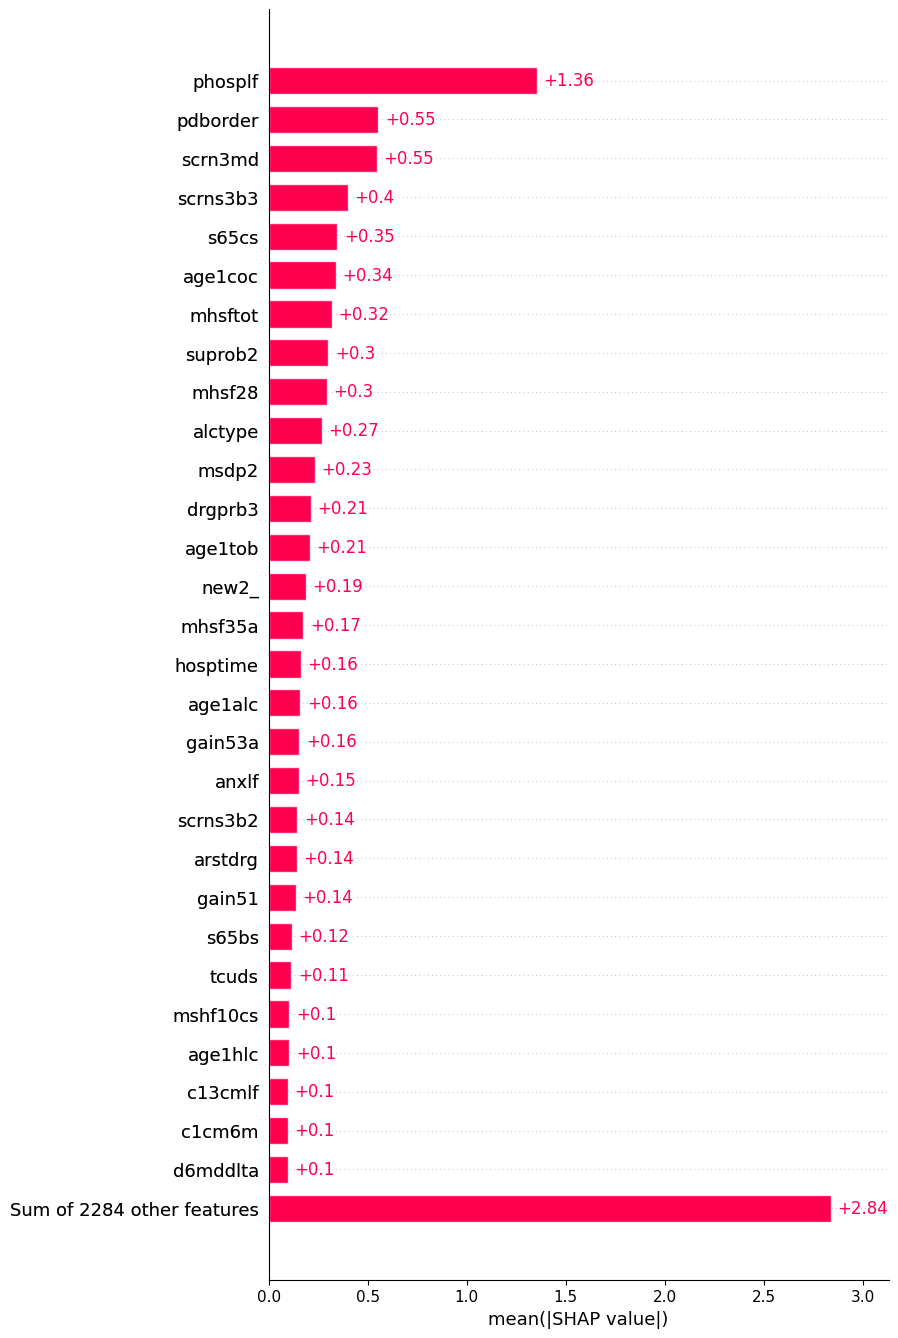

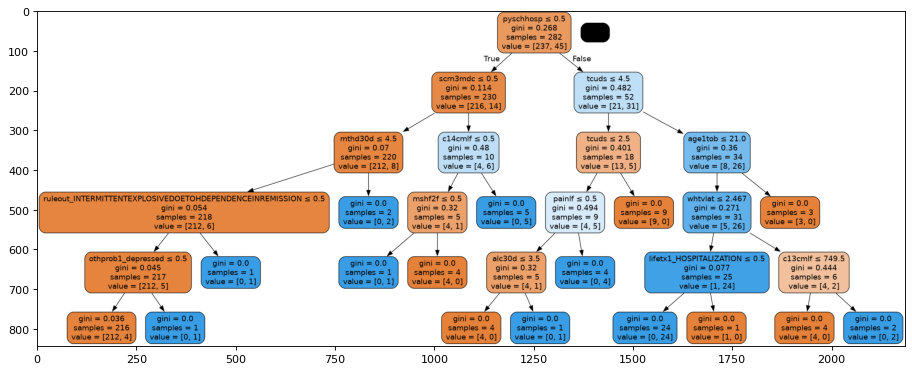

CatBoost without Suicide
0:	learn: 0.6086767	total: 11.1ms	remaining: 1.1s
1:	learn: 0.5344731	total: 20.1ms	remaining: 984ms
2:	learn: 0.4788900	total: 30.6ms	remaining: 990ms
3:	learn: 0.4380883	total: 39.3ms	remaining: 943ms
4:	learn: 0.3984201	total: 48.3ms	remaining: 917ms
5:	learn: 0.3583154	total: 57.2ms	remaining: 897ms
6:	learn: 0.3294217	total: 67.3ms	remaining: 894ms
7:	learn: 0.2989921	total: 77.2ms	remaining: 888ms
8:	learn: 0.2825038	total: 87.6ms	remaining: 886ms
9:	learn: 0.2612229	total: 98.3ms	remaining: 885ms
10:	learn: 0.2486186	total: 108ms	remaining: 877ms
11:	learn: 0.2396568	total: 118ms	remaining: 865ms
12:	learn: 0.2219844	total: 126ms	remaining: 844ms
13:	learn: 0.2111003	total: 134ms	remaining: 820ms
14:	learn: 0.2027330	total: 144ms	remaining: 817ms
15:	learn: 0.1963330	total: 155ms	remaining: 812ms
16:	learn: 0.1883487	total: 166ms	remaining: 812ms
17:	learn: 0.1857940	total: 177ms	remaining: 804ms
18:	learn: 0.1840447	total: 186ms	remaining: 794ms
19:	lea

In [45]:
#executing models WITHOUT SUICIDE IDEATION on ORIGINAL PROCESSED DATASET #1
y_pred_xgb = XGBoost(X_train, y_train, X_test, X, "without Suicide") #without suicide ideation

y_pred_rf = RandomForest(X_train, y_train, X_test, "without Suicide") #without suicide ideation

y_prob_nn = NN(X_train, y_train, X_test, y_test, X, "without suicide") #without suicide ideation

y_pred_dt = DecisionTree(X_train, y_train, X_test, X, "without suicide") #without suicide ideation

y_pred_logr = LogReg(X_train, y_train, X_test, "without suicide") #without suicide ideation

y_prob_lr = LinearReg(X_train, y_train, X_test) #without suicide ideation

y_pred_cat = catBoost(X_train, y_train, X_test, "without Suicide") #without suicide ideation

[14:27:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


      feature  importance
382   mhsf28a    1.920677
149    sidelf    1.330007
413    gain44    0.631509
154   phosplf    0.491269
41     age1jl    0.332266
195   age1coc    0.312735
29        job    0.283478
264   alctype    0.230005
562  pdborder    0.225392
582   aspdtot    0.219845
28     drvlic    0.216675
278   drgprb6    0.192592
719  mshf10cs    0.190054
64     c7cm6m    0.157834
196     coc6m    0.152871
180   age1tob    0.146488
285   suprob2    0.139043
33    arstdrg    0.132136
143    painlf    0.128803
10      clive    0.126802
287    qtsubs    0.123646
803  scrns3c3    0.107104
225   age1met    0.093402
543  hosptime    0.087426
31     allmon    0.076270
576     minic    0.070147
782     s64as    0.069395
CatBoost with Suicide
0:	learn: 0.5549261	total: 9.19ms	remaining: 909ms
1:	learn: 0.4499076	total: 17.8ms	remaining: 870ms
2:	learn: 0.3756642	total: 27.6ms	remaining: 893ms
3:	learn: 0.3208851	total: 37ms	remaining: 889ms
4:	learn: 0.2776312	total: 46.4ms	remaining: 881

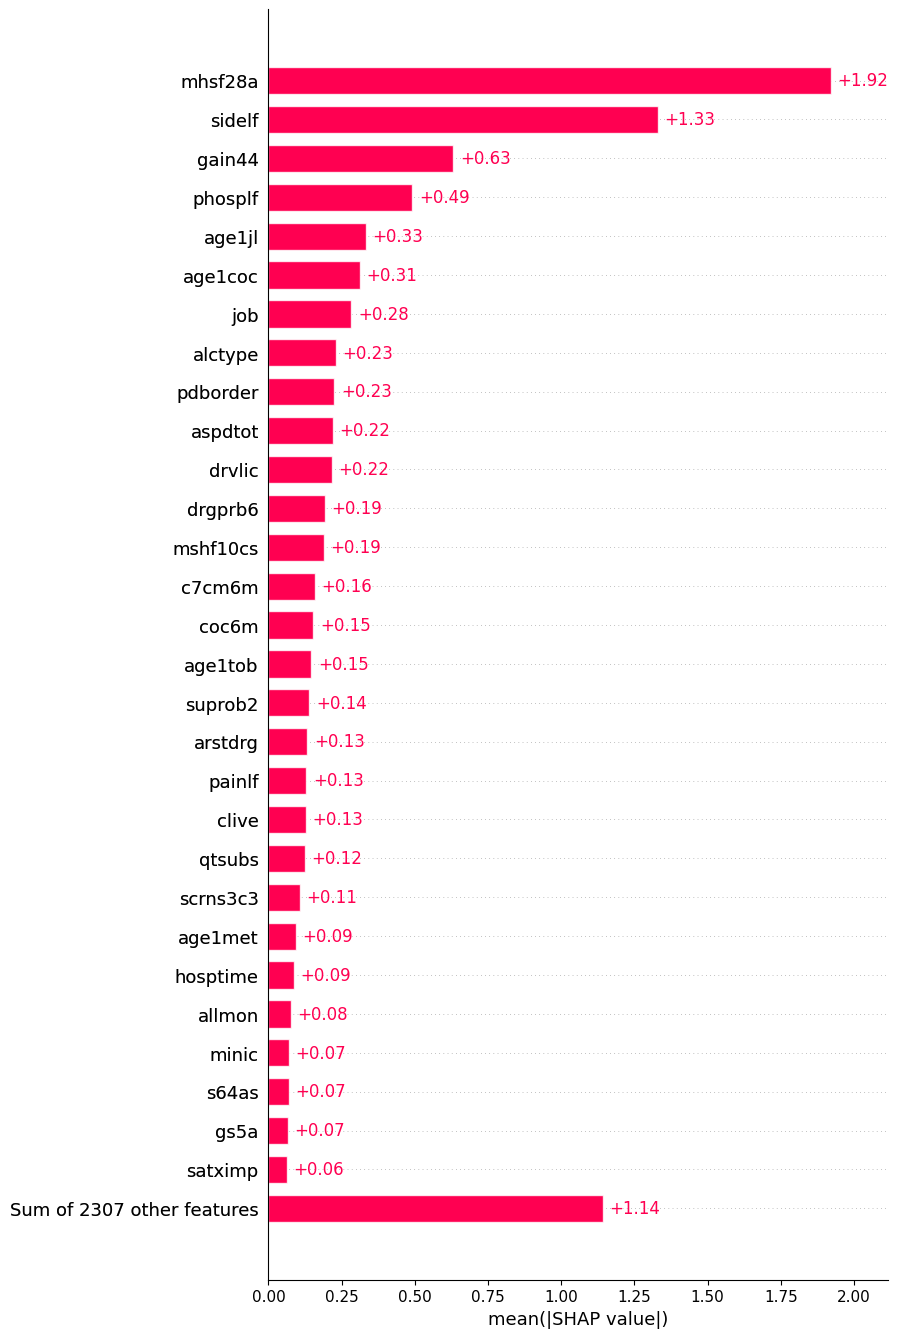

In [46]:
#executing models WITH SUICIDE IDEATION on ORIGINAL PROCESSED DATASET #2
y_pred_xgb_s = XGBoost(X_train_s, y_train_s, X_test_s, X_s, "with Suicide") #with suicide ideation

y_pred_rf_s = RandomForest(X_train_s, y_train_s, X_test_s, "with Suicide") #with suicide ideation

y_pred_cat_s = catBoost(X_train_s, y_train_s, X_test_s, "with Suicide") #without suicide ideation

#Neural Network with suicide ideation not in scope of paper

#Decision Tree with suicide ideation not in scope of paper

#Logistic Regression with suicide ideation not in scope of paper

#Linear Regression with suicide ideation not in scope of paper

# Model Execution on Reduced Dataset

Below are the same models being executed for SHAP reduced datasets.

[14:27:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


     feature  importance
0    phosplf    1.528117
1   scrns3b3    0.918380
5    suprob2    0.603212
2   pdborder    0.556634
4    scrn3md    0.518509
8    age1coc    0.482048
7    alctype    0.461738
26    c1cm30    0.450136
6      s65cs    0.417655
11   age1tob    0.372769
10     new2_    0.346483
9    age1alc    0.326128
12   drgprb3    0.281574
14  hosptime    0.271791
21    depend    0.266838
20   arstdrg    0.254098
13   mhsf35a    0.249910
18  d6mddlta    0.243559
3    mhsftot    0.241981
15     anxlf    0.227091
16    mhsf28    0.215196
24       age    0.186677
19    majsup    0.148760
17      s65a    0.142253
25     tcuds    0.137970
22   drgprb2    0.130283
23  scrns3b2    0.126722
Epoch 1/150
29/29 [==============================] - 1s 2ms/step - loss: 0.5064 - accuracy: 0.8440
Epoch 2/150
29/29 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8404
Epoch 3/150
29/29 [==============================] - 0s 3ms/step - loss: 0.4268 - accuracy: 0.8404
Epo

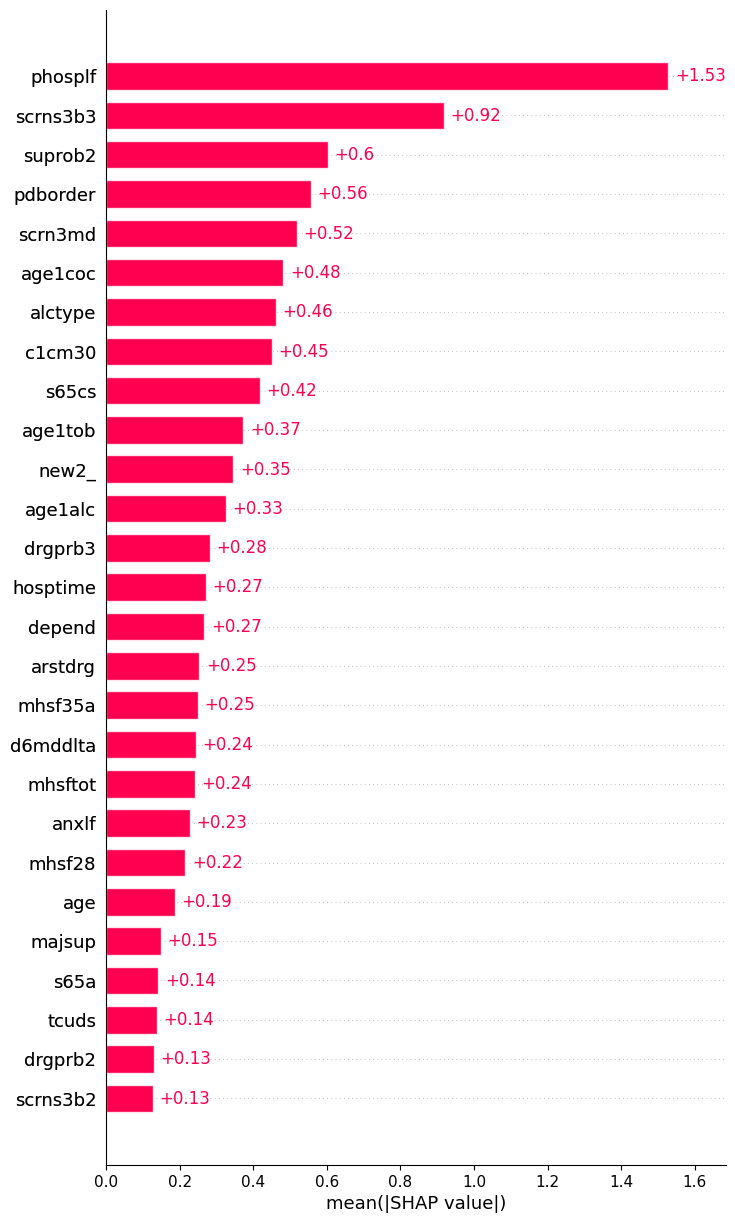

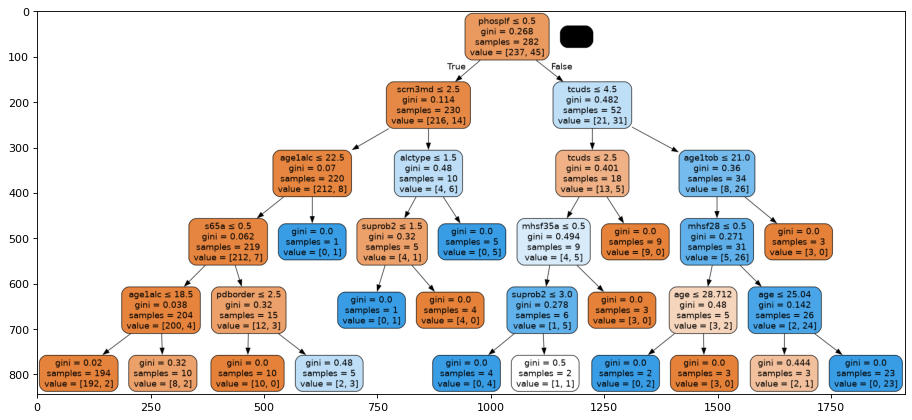

CatBoost reduced without Suicide
0:	learn: 0.5846077	total: 1.96ms	remaining: 194ms
1:	learn: 0.5078737	total: 2.78ms	remaining: 136ms
2:	learn: 0.4347213	total: 3.8ms	remaining: 123ms
3:	learn: 0.3827638	total: 4.81ms	remaining: 115ms
4:	learn: 0.3352858	total: 6.1ms	remaining: 116ms
5:	learn: 0.3125231	total: 7.2ms	remaining: 113ms
6:	learn: 0.2796294	total: 8.21ms	remaining: 109ms
7:	learn: 0.2550176	total: 9.11ms	remaining: 105ms
8:	learn: 0.2431530	total: 9.95ms	remaining: 101ms
9:	learn: 0.2286869	total: 10.7ms	remaining: 96.6ms
10:	learn: 0.2152749	total: 11.5ms	remaining: 92.7ms
11:	learn: 0.2057325	total: 12.2ms	remaining: 89.4ms
12:	learn: 0.1937750	total: 13.1ms	remaining: 87.9ms
13:	learn: 0.1834882	total: 13.9ms	remaining: 85.3ms
14:	learn: 0.1757198	total: 14.6ms	remaining: 82.8ms
15:	learn: 0.1681549	total: 15.4ms	remaining: 80.7ms
16:	learn: 0.1614761	total: 16.1ms	remaining: 78.5ms
17:	learn: 0.1572212	total: 16.8ms	remaining: 76.5ms
18:	learn: 0.1520311	total: 17.5ms	

In [47]:
#executing models WITHOUT SUICIDE IDEATION on SHAP REDUCED DATASET #3
y_pred_xgb_r = XGBoost(X_train_r, y_train_r, X_test_r, X_r, "reduced without Suicide") #without suicide ideation

y_pred_rf_r = RandomForest(X_train_r, y_train_r, X_test_r, "reduced without Suicide") #without suicide ideation

y_prob_nn_r = NN(X_train_r, y_train_r, X_test_r, y_test_r, X_r, "reduced without suicide") #without suicide ideation

y_pred_dt_r = DecisionTree(X_train_r, y_train_r, X_test_r, X_r, "reduced without suicide") #without suicide ideation

y_pred_logr_r = LogReg(X_train_r, y_train_r, X_test_r, "reduced without suicide") #without suicide ideation

y_prob_lr_r = LinearReg(X_train_r, y_train_r, X_test_r) #without suicide ideation

y_pred_cat_r = catBoost(X_train_r, y_train_r, X_test_r, "reduced without Suicide") #without suicide ideation

[14:27:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


     feature  importance
0    mhsf28a    1.897134
1     sidelf    1.401281
2     gain44    0.716031
3    phosplf    0.459878
5        job    0.457563
6    age1coc    0.443301
4     age1jl    0.440061
11   alctype    0.374758
9      coc6m    0.321921
7     drvlic    0.317607
18  pdborder    0.300665
14  mshf10cs    0.248143
20   drgprb6    0.248101
10   aspdtot    0.245847
13    c7cm6m    0.218149
15     clive    0.215235
21  scrns3c3    0.212625
8    gain44a    0.212541
12   age1tob    0.178345
22   arstdrg    0.167398
16   gain53a    0.152530
23    allmon    0.112065
25      gs5a    0.097945
19    age1mj    0.081693
17   suprob2    0.072486
24  hosptime    0.068510
26    depend    0.029756
CatBoost reduced with Suicide
0:	learn: 0.5279862	total: 1.61ms	remaining: 160ms
1:	learn: 0.4368780	total: 2.45ms	remaining: 120ms
2:	learn: 0.3397502	total: 3.2ms	remaining: 103ms
3:	learn: 0.2901152	total: 3.83ms	remaining: 92.1ms
4:	learn: 0.2499809	total: 4.55ms	remaining: 86.5ms
5:	learn: 0.22

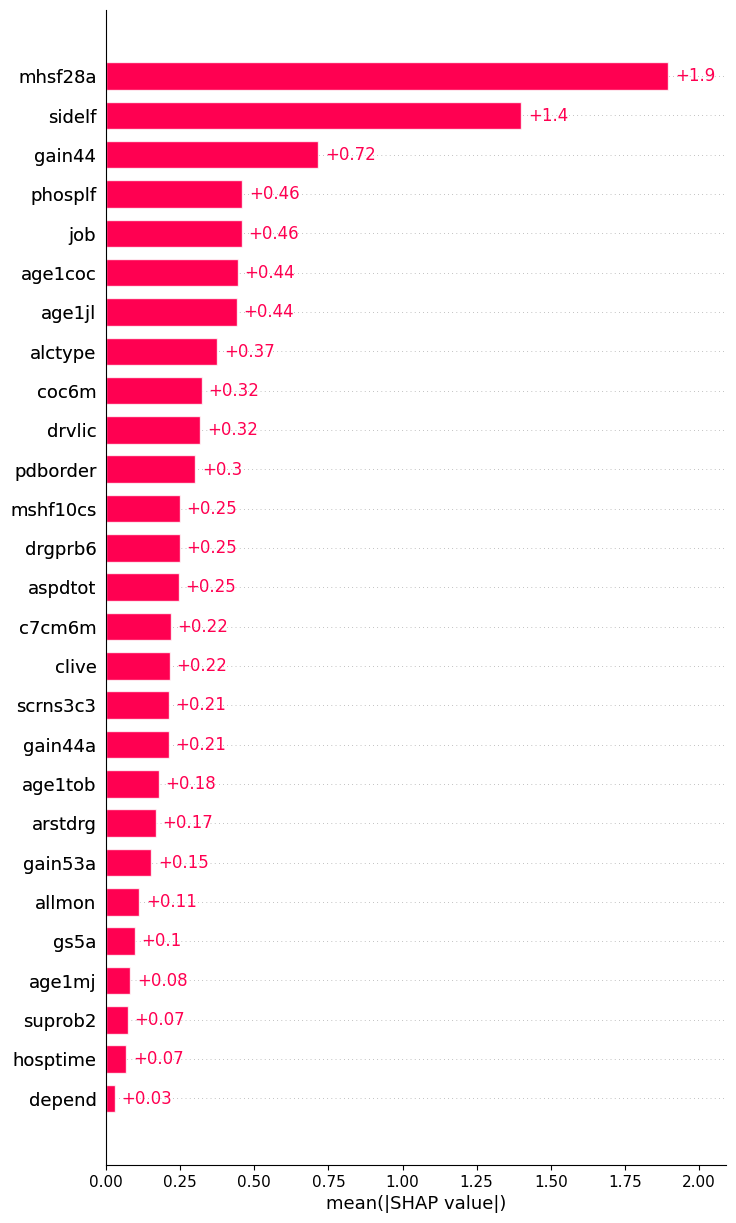

In [48]:
#executing models WITH SUICIDE IDEATION on SHAP REDUCED DATASET #4
y_pred_xgb_rs = XGBoost(X_train_rs, y_train_rs, X_test_rs, X_rs, "reduced with Suicide") #with suicide ideation

y_pred_rf_rs = RandomForest(X_train_rs, y_train_rs, X_test_rs, "reduced with Suicide") #with suicide ideation

y_pred_cat_rs = catBoost(X_train_rs, y_train_rs, X_test_rs, "reduced with Suicide") #with suicide ideation

#Neural Network with suicide ideation not in scope of paper

#Decision Tree with suicide ideation not in scope of paper

#Logistic Regression with suicide ideation not in scope of paper

#Linear Regression with suicide ideation not in scope of paper

In [49]:
#converting probabilities to predictions for Linear Regression and Neural Network

y_pred_lr = y_prob_lr.copy() #without suicide ideation Linear Regression
y_pred_lr[y_pred_lr<0.5] = 0
y_pred_lr[y_pred_lr>=0.5] = 1

y_pred_nn = y_prob_nn.copy() #without suicide ideation Neural Network
y_pred_nn[y_pred_nn<0.5] = 0
y_pred_nn[y_pred_nn>=0.5] = 1

y_pred_lr_r = y_prob_lr_r.copy() #reduced dataset without suicide ideation Linear Regression
y_pred_lr_r[y_pred_lr_r<0.5] = 0
y_pred_lr_r[y_pred_lr_r>=0.5] = 1

y_pred_nn_r = y_prob_nn_r.copy() #reduced dataset without suicide ideation Neural Network
y_pred_nn_r[y_pred_nn_r<0.5] = 0
y_pred_nn_r[y_pred_nn_r>=0.5] = 1

# Printing Performance Tables

         Metrics     XGB  XGB_si      RF   RF_si     CAT  CAT_si      NN  \
0   Accuracy(%):  88.730  92.960  83.100  88.730  85.920  88.730  77.460   
1      F1-Score:   0.799   0.870   0.651   0.785   0.731   0.767   0.491   
2     Precision:   0.887   0.930   0.831   0.887   0.859   0.887   0.775   
3   Sensitivity:   0.571   0.643   0.286   0.500   0.429   0.429   0.071   
4           AUC:   0.768   0.821   0.625   0.741   0.697   0.714   0.508   
5           PPV:   0.800   1.000   0.667   0.875   0.750   1.000   0.250   
6       Logloss:   1.297   0.811   1.946   1.297   1.622   1.297   0.653   
7        True +:   8.000   9.000   4.000   7.000   6.000   6.000   1.000   
8        True -:  55.000  57.000  55.000  56.000  55.000  57.000  54.000   
9       False +:   2.000   0.000   2.000   1.000   2.000   0.000   3.000   
10      False -:   6.000   5.000  10.000   7.000   8.000   8.000  13.000   

        DT     LOG     LIN  
0   83.100  74.650  67.610  
1    0.718   0.620   0.546  


<Figure size 640x480 with 0 Axes>

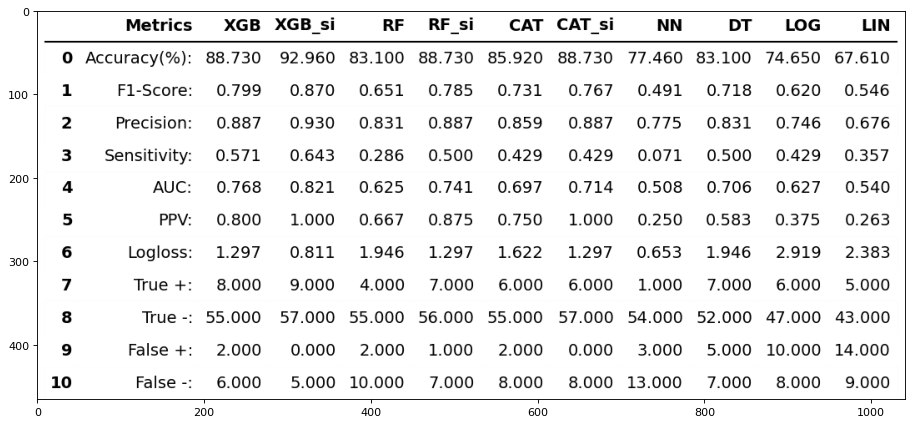

In [50]:
#Table visualization for original dataset models
gen_performance_metrics("XGB" , y_test, y_pred_xgb)
gen_performance_metrics("XGB_si" , y_test, y_pred_xgb_s)
gen_performance_metrics("RF" , y_test , y_pred_rf)
gen_performance_metrics("RF_si" , y_test_s, y_pred_rf_s)
gen_performance_metrics("CAT" , y_test, y_pred_cat)
gen_performance_metrics("CAT_si" , y_test, y_pred_cat_s)
gen_performance_metrics_prob("NN" , y_test, y_pred_nn , y_prob_nn)
gen_performance_metrics("DT" , y_test , y_pred_dt)
gen_performance_metrics("LOG" , y_test, y_pred_logr)
gen_performance_metrics_prob("LIN" , y_test, y_pred_lr , y_prob_lr)

print(table_df)
plt.figure(3)
#plt.rcParams["figure.figsize"] = (20,20)
figure(figsize=(14, 12), dpi=80)

if (balanceDataset == False):
    fileName = "original table no balance.png"
else:
    fileName = "original table balanced.png"

import dataframe_image as dfi
dfi.export(
    table_df,
    fileName,
    table_conversion="matplotlib"
)

img = mpimg.imread("/kaggle/working/" + fileName)
plt.imshow(img)
interactive(True)
plt.show()

         Metrics     XGB  XGB_si      RF   RF_si     CAT  CAT_si      NN  \
0   Accuracy(%):  87.320  92.960  87.320  90.140  87.320  90.140  85.920   
1      F1-Score:   0.782   0.879   0.767   0.818   0.767   0.818   0.778   
2     Precision:   0.873   0.930   0.873   0.901   0.873   0.901   0.859   
3   Sensitivity:   0.571   0.714   0.500   0.571   0.500   0.571   0.643   
4           AUC:   0.759   0.848   0.732   0.777   0.732   0.777   0.801   
5           PPV:   0.727   0.909   0.778   0.889   0.778   0.889   0.643   
6       Logloss:   1.459   0.811   1.459   1.135   1.459   1.135   0.643   
7        True +:   8.000  10.000   7.000   8.000   7.000   8.000   9.000   
8        True -:  54.000  56.000  55.000  56.000  55.000  56.000  52.000   
9       False +:   3.000   1.000   2.000   1.000   2.000   1.000   5.000   
10      False -:   6.000   4.000   7.000   6.000   7.000   6.000   5.000   

        DT     LOG     LIN  
0   83.100  87.320  87.320  
1    0.733   0.794   0.767  


<Figure size 640x480 with 0 Axes>

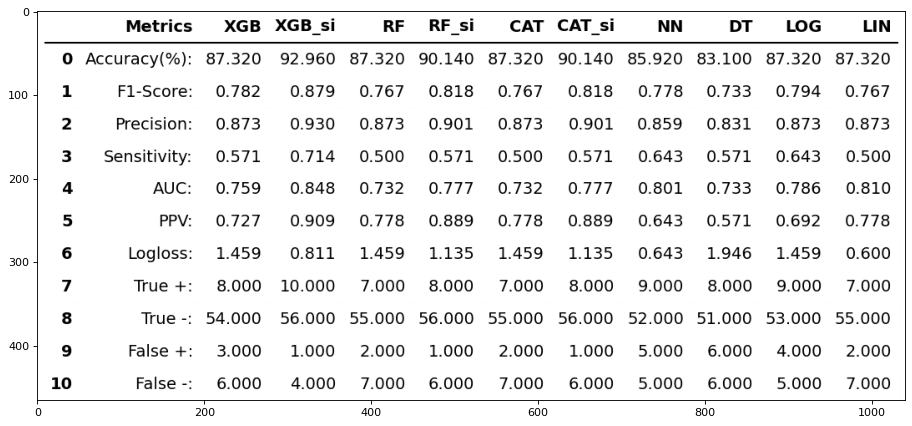

In [51]:
#Table visualization for reduced dataset models
gen_performance_metrics("XGB" , y_test_r, y_pred_xgb_r)
gen_performance_metrics("XGB_si" , y_test_rs, y_pred_xgb_rs)
gen_performance_metrics("RF" , y_test_r , y_pred_rf_r)
gen_performance_metrics("RF_si" , y_test_rs, y_pred_rf_rs)
gen_performance_metrics("CAT" , y_test, y_pred_cat_r)
gen_performance_metrics("CAT_si" , y_test, y_pred_cat_rs)
gen_performance_metrics_prob("NN" , y_test_r, y_pred_nn_r , y_prob_nn_r)
gen_performance_metrics("DT" , y_test_r , y_pred_dt_r)
gen_performance_metrics("LOG" , y_test_r, y_pred_logr_r)
gen_performance_metrics_prob("LIN" , y_test_r, y_pred_lr_r , y_prob_lr_r)

print(table_df)
plt.figure(4)
#plt.rcParams["figure.figsize"] = (20,20)
figure(figsize=(14, 12), dpi=80)

fileName = "reduced table"

if (balanceDataset == False):
    fileName = fileName + " no balance"
else:
    fileName = fileName + " balanced"

import dataframe_image as dfi
dfi.export(
    table_df,
    fileName+".png",
    table_conversion="matplotlib"
)

img = mpimg.imread("/kaggle/working/" + fileName + ".png")
plt.imshow(img)
interactive(True)
plt.show()

# Anchor Rule Generations

In this section, we are utilizing anchor to create explanatory rules using XGBoost models using SHAP reduced datasets.
The generated anchor rules are saved in separate .txt files for further analysis. 

In [52]:
!pip install anchor-exp
from anchor import utils
from anchor import anchor_tabular

In [53]:
#function for executing XGBoost
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, f1_score

def XGBoost(xTrain, yTrain, yTest, xTest, x, pngName): #x is the original features dataset, X, X_s, X_r
    # Init classifier
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.3, 
                               booster='gbtree', max_depth=5, n_estimators=100)
    # Fit
    xgb_cl.fit(xTrain, yTrain)
    # Predict
    yPred = xgb_cl.predict(xTest)

    #Anchor explaination below
    # Create a DataFrame with the feature names
    feature_names = list(xTrain.columns)
    df = pd.DataFrame(xTrain, columns=feature_names)

    # Create an instance of the AnchorTabularExplainer
    explainer = anchor_tabular.AnchorTabularExplainer(
        class_names=['0', '1'],  # List of class names
        feature_names=feature_names,  # List of feature names
        categorical_names={},  # Dictionary of categorical feature names
        train_data=xTrain.values,  # DataFrame of training data
        discretizer='decile'  # discretization method
    )

    precision_val = 0
    coverage_val = 0
    test_precision_val = 0
    test_coverage_val = 0
    mae_val = 0
    acc_val = 0
    yPred_instances = []  # Store y_pred_instance values for each instance
    #explainer.save_to_file(
    # Open the file in write mode
    fileDir = '/kaggle/working/Anchor ' + pngName + '.txt'
    with open(fileDir, 'w') as f:
        # Write text to the file
        for index in range (0, len(xTest)):
            print("", file=f)
            # Choose a prediction to explain
            idx = index #index of records in testing depends on test/train split. currently 0-70
            instance = xTest.iloc[[idx]]
            predict_fn = lambda x: xgb_cl.predict(x)

            # Generate an explanation for the chosen prediction
            explanation = explainer.explain_instance(
                instance.values[0],
                predict_fn,
                threshold=0.95
            )

            y_pred_instance = predict_fn(instance.values)
            # Ensure y_pred_instance is a 1-dimensional array
            y_pred_instance = np.squeeze(y_pred_instance)

            # Get the corresponding true label from yTest and convert to 1-dimensional array
            y_true = np.array([yTest.iloc[idx]])

            mae = mean_absolute_error(y_true, y_pred_instance.reshape(1, -1))
            accuracy = accuracy_score(y_true, y_pred_instance.reshape(1, -1))

            acc_val = acc_val + accuracy
            mae_val = mae_val + mae
            # Store y_pred_instance for each instance
            yPred_instances.append(np.ravel(y_pred_instance))

            # Print the explanation
            print('Example {}:'.format(idx), file=f)
            print('Prediction: {}'.format(y_pred_instance), file=f)
            print('Explanation: {}'.format(explanation), file=f)
            print('Anchor: %s' % (' AND '.join(explanation.names())), file=f)
            print('Precision: %.2f' % explanation.precision(), file=f)
            print('Coverage: %.2f' % explanation.coverage(), file=f)
            print('Mean Absolute Error (MAE): {}'.format(mae), file=f)
            print('Accuracy: {}'.format(accuracy), file=f)


            # Get test examples where the anchor applies
            fit_anchor = np.where(np.all(xTest.values[:, explanation.features()] == instance.values[0][explanation.features()], axis=1))[0]
            print('Anchor test precision: %.2f' % (np.mean(predict_fn(xTest.values[fit_anchor]) == predict_fn(instance.values))), file=f)
            print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(xTest.shape[0])), file=f)

            precision_val = precision_val + explanation.precision()
            coverage_val = coverage_val + explanation.coverage()
            test_precision_val = test_precision_val + np.mean(predict_fn(xTest.values[fit_anchor]) == predict_fn(instance.values))
            test_coverage_val = test_coverage_val + (fit_anchor.shape[0] / float(xTest.shape[0]))


    # The file is automatically closed when the `with` block is exited

    print("!FILE WRITING HAS BEEN COMPLETED!")
    num_instances = xTest.shape[0]
    print(num_instances)
    precision_val = precision_val / num_instances
    coverage_val = coverage_val / num_instances
    test_precision_val = test_precision_val / num_instances
    test_coverage_val = test_coverage_val / num_instances
    print("Average Precision: " , precision_val)
    print("Average Coverage: " , coverage_val)
    print("Average Test Precision: " , test_precision_val)
    print("Average Test Coverage: " , test_coverage_val)
    mae_val = mae_val / num_instances
    acc_val = acc_val / num_instances
    print("Average MAE: ", mae_val)
    print("Accuracy: " , acc_val)

    # Create a new yPred based on stored y_pred_instance values
    yPred_anchor = np.concatenate(yPred_instances)
    # Calculate and print overall recall and F1 score for entire y_true and yPred
    recall_val = recall_score(yTest, yPred_anchor)
    f1_score_val = f1_score(yTest, yPred_anchor)

    print("Recall: " , recall_val)
    print("F1 Score: " , f1_score_val)

    return yPred.copy()

In [54]:
#executing XGB WITHOUT SUICIDE IDEATION on SHAP REDUCED DATASET
y_pred_xgb_r = XGBoost(X_train_r, y_train_r, y_test_r, X_test_r, X_r, "reduced without Suicide") #without suicide ideation

!FILE WRITING HAS BEEN COMPLETED!
71
Average Precision:  0.9901429772426207
Average Coverage:  0.3302929577464789
Average Test Precision:  0.9964788732394366
Average Test Coverage:  0.2201944058718509
Average MAE:  0.1267605633802817
Accuracy:  0.8732394366197183
Recall:  0.5714285714285714
F1 Score:  0.64


In [55]:
#executing XGB WITH SUICIDE IDEATION on SHAP REDUCED DATASET
y_pred_xgb_rs = XGBoost(X_train_rs, y_train_rs, y_test_rs, X_test_rs, X_rs, "reduced with Suicide") #with suicide ideation

!FILE WRITING HAS BEEN COMPLETED!
71
Average Precision:  0.9908922758272296
Average Coverage:  0.5519028169014082
Average Test Precision:  0.9881336239081503
Average Test Coverage:  0.4705415592144418
Average MAE:  0.07042253521126761
Accuracy:  0.9295774647887324
Recall:  0.7142857142857143
F1 Score:  0.8
